- Authors : Abhishek

An organization wanted to mine association rules of frequently bought items from its stores and suggest some recommendations to its customers. 
As a data scientist, you are required to recognize patterns from the available data and evaluate efficacy of methods to obtain patterns. 

Your activities should include - performing various activities pertaining to the data such as, preparing the dataset for analysis; investigating the relationships in the data set with visualization; identify frequent patterns; formulate association rules and evaluate quality of rules.

Demonstrate KDD process with following activities:
- Problem statement
- Perform exploratory data analysis
- Preprocess the data. Identify relevant & irrelevant attributes for the problem.
- Propose parameters such as support, confidence etc.  
- Discover frequent patterns
- Iterate previous steps by varying parameters
- Formulate association rules
- Compare association rules
- Briefly explain importance of discovered rules

Following are some points for you to take note of, while doing the assignment:
- The data in some of the rows in the data set may be noisy, sparse.
- State all your assumptions clearly
- Provide clear explanations to explain your stand


In [1]:
!pip install apyori
!pip install researchpy
!pip install openpyxl
!pip install xlrd

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=cf074e10ddf754ee137bd20556994c09d1ec15bcd47d0ae19327c91ce1556591
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori
     |████████████████████████████████| 242 kB 278 kB/s 
     |████████████████████████████████| 96 kB 376 kB/s 


In [2]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format

import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import random

from apyori import apriori
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import os
import json
from datetime import datetime
from itertools import combinations, groupby
from collections import Counter

import itertools
import researchpy
import networkx as nx

import time
import gc
import collections

begin = time.time() # Mark the start
gc.collect()

pd.pandas.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("precision", 3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
df = pd.read_csv(r'../input/market-basket-analysis/apriori.csv', header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape # 7501 Transactions # Max no. of items purchased = 20

(7501, 20)

In [5]:
df.info() # Original dataset has multiple instances as nan as individual transactions might not hold all possible item list

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [6]:
records = []
for i in range(0, df.shape[0]):
    records.append([str(df.values[i,j]) for j in range(0, df.shape[1])])
    
print([x for x in records[1] if str(x) != 'nan']) # Second Transaction Data

['burgers', 'meatballs', 'eggs']


In [7]:
# Unique items # To create the Transactional Encoding of the data in a binary representation 

unq = []
for col in df.columns:
    unq.append(list(set(df[col].unique().tolist())))
    
flattenItemList = [item for sublist in unq for item in sublist]

In [8]:
# Repeated items # one of the items is 'nan' -> needs to be removed too.

# Certain spelling errors are seen : 'whole weat flour'
print([item for item, count in collections.Counter(flattenItemList).items() if count > 1])

['whole wheat pasta', 'shallot', 'light cream', 'herb & pepper', 'butter', 'strawberries', 'cauliflower', 'french wine', 'frozen vegetables', 'meatballs', 'sandwich', 'body spray', 'candy bars', 'mushroom cream sauce', 'frozen smoothie', 'champagne', 'cooking oil', 'antioxydant juice', 'energy drink', 'soda', 'yogurt cake', 'eggs', 'energy bar', 'whole wheat rice', 'spinach', 'almonds', 'pepper', 'oatmeal', 'nonfat milk', 'burgers', 'cider', 'flax seed', 'eggplant', 'sparkling water', 'grated cheese', 'mint', 'olive oil', 'salad', 'hot dogs', 'dessert wine', 'pet food', 'soup', 'chicken', 'french fries', 'green tea', 'mint green tea', 'tomato sauce', 'honey', 'vegetables mix', 'salmon', 'whole weat flour', 'melons', 'spaghetti', 'fresh bread', 'blueberries', 'cake', 'babies food', 'parmesan cheese', 'muffins', 'fromage blanc', 'chocolate', 'carrots', 'cream', 'brownies', 'mayonnaise', 'fresh tuna', 'rice', 'burger sauce', 'chocolate bread', 'escalope', 'green grapes', 'bramble', 'black

In [9]:
uniqueItems = list(set(flattenItemList)) # extracting only the unique items for building the DataFrame of transactions
uniqueItems[10] # example 

'meatballs'

In [10]:
uniqueItems = [x for x in uniqueItems if str(x) != 'nan'] # datasets contained 'nan' as string
len(uniqueItems)

119

In [11]:
%%time
def buildDataset(df, uniqueItems):
    """
    Transactional Encoding of the DataSet.
    Building a dataframe of zeros to accomodate the items by replacing 0's with 1's
    Input : List of unique items
    Output : DataFrame of 0's & 1's with columns as unique items in the list 
    and no. of observations as rows filled with occurences of items.
    
    """
    dfCleaned = pd.DataFrame(np.zeros((df.shape[0], len(uniqueItems))), columns=uniqueItems, dtype=np.int32)
    
    for colIdx, item in enumerate(dfCleaned.columns.tolist()): # Take one column at a time
        for rowIdx, row in df.iterrows(): # Take items from the first row
            rowVals = row.values # Compare with uniqueItems
            if item in rowVals:
                dfCleaned.iloc[rowIdx, colIdx] = 1
            
    return dfCleaned

df = buildDataset(df, uniqueItems)
df.head(3)

CPU times: user 54.9 s, sys: 4.4 ms, total: 54.9 s
Wall time: 54.9 s


,whole wheat pasta,shallot,light cream,herb & pepper,butter,strawberries,cauliflower,french wine,frozen vegetables,meatballs,sandwich,body spray,candy bars,mushroom cream sauce,frozen smoothie,champagne,cooking oil,antioxydant juice,water spray,napkins,energy drink,soda,yogurt cake,eggs,energy bar,whole wheat rice,spinach,almonds,tea,pepper,oatmeal,nonfat milk,burgers,cider,flax seed,eggplant,sparkling water,grated cheese,mint,olive oil,salad,hot dogs,dessert wine,zucchini,pet food,soup,chicken,french fries,green tea,mint green tea,tomato sauce,honey,vegetables mix,salmon,whole weat flour,melons,spaghetti,fresh bread,blueberries,cake,babies food,parmesan cheese,muffins,avocado,fromage blanc,chocolate,carrots,cream,brownies,mayonnaise,fresh tuna,rice,burger sauce,chocolate bread,escalope,green grapes,bramble,black tea,tomatoes,milk,strong cheese,yams,red wine,tomato juice,bug spray,corn,oil,ground beef,ketchup,bacon,chili,gums,chutney,turkey,gluten free bar,magazines,low fat yogurt,clothes accessories,toothpaste,mashed potato,cottage cheese,white wine,shampoo,pancakes,hand protein bar,asparagus,ham,salt,extra dark chocolate,barbecue sauce,pickles,pasta,green beans,cereals,shrimp,light mayo,protein bar,cookies,mineral water
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
df.tail(3)

,whole wheat pasta,shallot,light cream,herb & pepper,butter,strawberries,cauliflower,french wine,frozen vegetables,meatballs,sandwich,body spray,candy bars,mushroom cream sauce,frozen smoothie,champagne,cooking oil,antioxydant juice,water spray,napkins,energy drink,soda,yogurt cake,eggs,energy bar,whole wheat rice,spinach,almonds,tea,pepper,oatmeal,nonfat milk,burgers,cider,flax seed,eggplant,sparkling water,grated cheese,mint,olive oil,salad,hot dogs,dessert wine,zucchini,pet food,soup,chicken,french fries,green tea,mint green tea,tomato sauce,honey,vegetables mix,salmon,whole weat flour,melons,spaghetti,fresh bread,blueberries,cake,babies food,parmesan cheese,muffins,avocado,fromage blanc,chocolate,carrots,cream,brownies,mayonnaise,fresh tuna,rice,burger sauce,chocolate bread,escalope,green grapes,bramble,black tea,tomatoes,milk,strong cheese,yams,red wine,tomato juice,bug spray,corn,oil,ground beef,ketchup,bacon,chili,gums,chutney,turkey,gluten free bar,magazines,low fat yogurt,clothes accessories,toothpaste,mashed potato,cottage cheese,white wine,shampoo,pancakes,hand protein bar,asparagus,ham,salt,extra dark chocolate,barbecue sauce,pickles,pasta,green beans,cereals,shrimp,light mayo,protein bar,cookies,mineral water
7498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df.sum()[:5] # Occurences of items (just the top 5 in sequence)

whole wheat pasta    221
shallot               58
light cream          117
herb & pepper        371
butter               226
dtype: int64

In [14]:
df.describe().loc[['count', 'mean', 'std']].sort_values(by = 'mean', axis=1, ascending=False) # To check the mean of the items across all 7501 transactions ; 
# spaghetti ; french fries ; eggs ; ground beef ; chocolate ; milk are the most frequently bought items.

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,burgers,cake,cookies,escalope,low fat yogurt,shrimp,tomatoes,olive oil,frozen smoothie,turkey,chicken,whole wheat rice,grated cheese,cooking oil,soup,herb & pepper,honey,champagne,fresh bread,salmon,brownies,avocado,hot dogs,cottage cheese,tomato juice,butter,whole wheat pasta,red wine,yogurt cake,light mayo,energy bar,energy drink,pepper,ham,vegetables mix,cereals,muffins,oil,french wine,fresh tuna,strawberries,meatballs,almonds,parmesan cheese,mushroom cream sauce,rice,protein bar,mint,white wine,pasta,light cream,carrots,black tea,tomato sauce,fromage blanc,gums,eggplant,extra dark chocolate,melons,body spray,yams,magazines,barbecue sauce,cider,nonfat milk,candy bars,zucchini,whole weat flour,blueberries,salt,flax seed,green grapes,antioxydant juice,green beans,bug spray,bacon,clothes accessories,toothpaste,shallot,strong cheese,spinach,gluten free bar,pet food,soda,sparkling water,chili,mayonnaise,pickles,burger sauce,mint green tea,hand protein bar,salad,shampoo,cauliflower,asparagus,corn,babies food,sandwich,dessert wine,ketchup,oatmeal,chocolate bread,mashed potato,chutney,tea,bramble,cream,napkins,water spray
count,"7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000","7,501.000"
mean,0.238,0.180,0.174,0.171,0.164,0.132,0.130,0.098,0.095,0.095,0.087,0.081,0.080,0.079,0.077,0.071,0.068,0.066,0.063,0.063,0.060,0.059,0.052,0.051,0.051,0.049,0.047,0.047,0.043,0.043,0.034,0.033,0.032,0.032,0.030,0.030,0.029,0.028,0.027,0.027,0.027,0.027,0.027,0.027,0.026,0.026,0.024,0.023,0.023,0.022,0.021,0.021,0.020,0.020,0.019,0.019,0.019,0.017,0.017,0.016,0.016,0.015,0.014,0.014,0.014,0.013,0.013,0.012,0.012,0.011,0.011,0.011,0.011,0.011,0.010,0.010,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.008,0.008,0.008,0.008,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.002,0.001,0.001,0.000
std,0.426,0.384,0.379,0.376,0.370,0.339,0.336,0.298,0.294,0.293,0.282,0.273,0.272,0.270,0.266,0.258,0.252,0.248,0.244,0.242,0.237,0.235,0.223,0.220,0.219,0.217,0.213,0.211,0.203,0.202,0.181,0.180,0.177,0.176,0.172,0.171,0.169,0.165,0.163,0.163,0.162,0.161,0.161,0.161,0.158,0.158,0.153,0.150,0.148,0.148,0.144,0.143,0.141,0.140,0.137,0.136,0.135,0.131,0.128,0.124,0.124,0.123,0.119,0.118,0.116,0.115,0.114,0.109,0.109,0.106,0.106,0.104,0.103,0.102,0.101,0.098,0.097,0.096,0.095,0.095,0.095,0.095,0.094,0.093,0.093,0.093,0.091,0.090,0.088,0.088,0.084,0.083,0.081,0.079,0.079,0.078,0.078,0.077,0.076,0.075,0

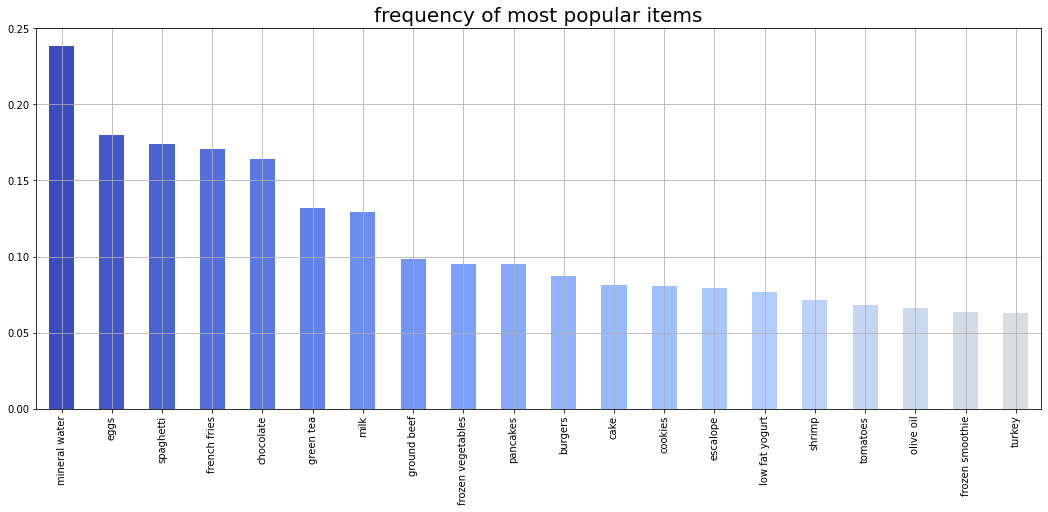

In [15]:
def plotOccurrence(df, n=20, ascending=False):
    """
    Plot of top support values : item's frequency of occurrence
    
    """
    plt.rcParams['figure.figsize'] = (18, 7)
    color = plt.cm.coolwarm(np.linspace(0, 1, 40))
    (df.sum() / df.shape[0]).sort_values(ascending=ascending).head(n).plot.bar(color = color)
    plt.title('frequency of most popular items', fontsize = 20)
    plt.xticks(rotation = 90 )
    plt.grid()
    plt.show()
    
plotOccurrence(df, n=20) # Mineral Water has the highest percentage of occurrence 

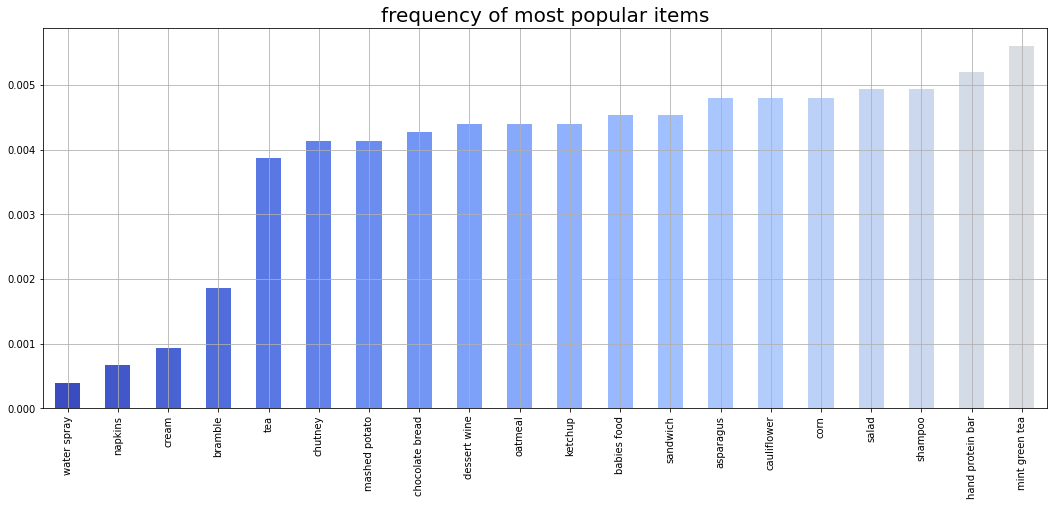

In [16]:
plotOccurrence(df, n=20, ascending=True) # Water Spray has the lowest percentage of occurrence 

In [17]:
def cramers_v(confusion_matrix):
    """ 
    Calculate Cramers V statistic for categorial-categorial association.
    Considering items & their occurences here as categories.
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [18]:
def find_association(method, data, columns, plot = True, returnCorr= False):
    """
    Finding associations b/w different metrics based on Cramer's rule.
    """
    
    df = data
    cols = columns
    corrM = np.zeros((len(cols),len(cols)))
    np.fill_diagonal(corrM, 1)

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v((pd.crosstab(df[col1], df[col2])).values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    
    corr = round(corr, 2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    if plot:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax = sns.heatmap(corr, cmap='coolwarm', annot=True, ax=ax, mask=mask, 
                         vmax=1.0, vmin=-1.0, linewidths=0.1,
                        annot_kws={"size": 9}, square=True, cbar=True); 
        ax.set_title("Correlation between Variables");

        plt.savefig("association.png", dpi = 300);
        plt.show()
    
    if returnCorr:
        return corr

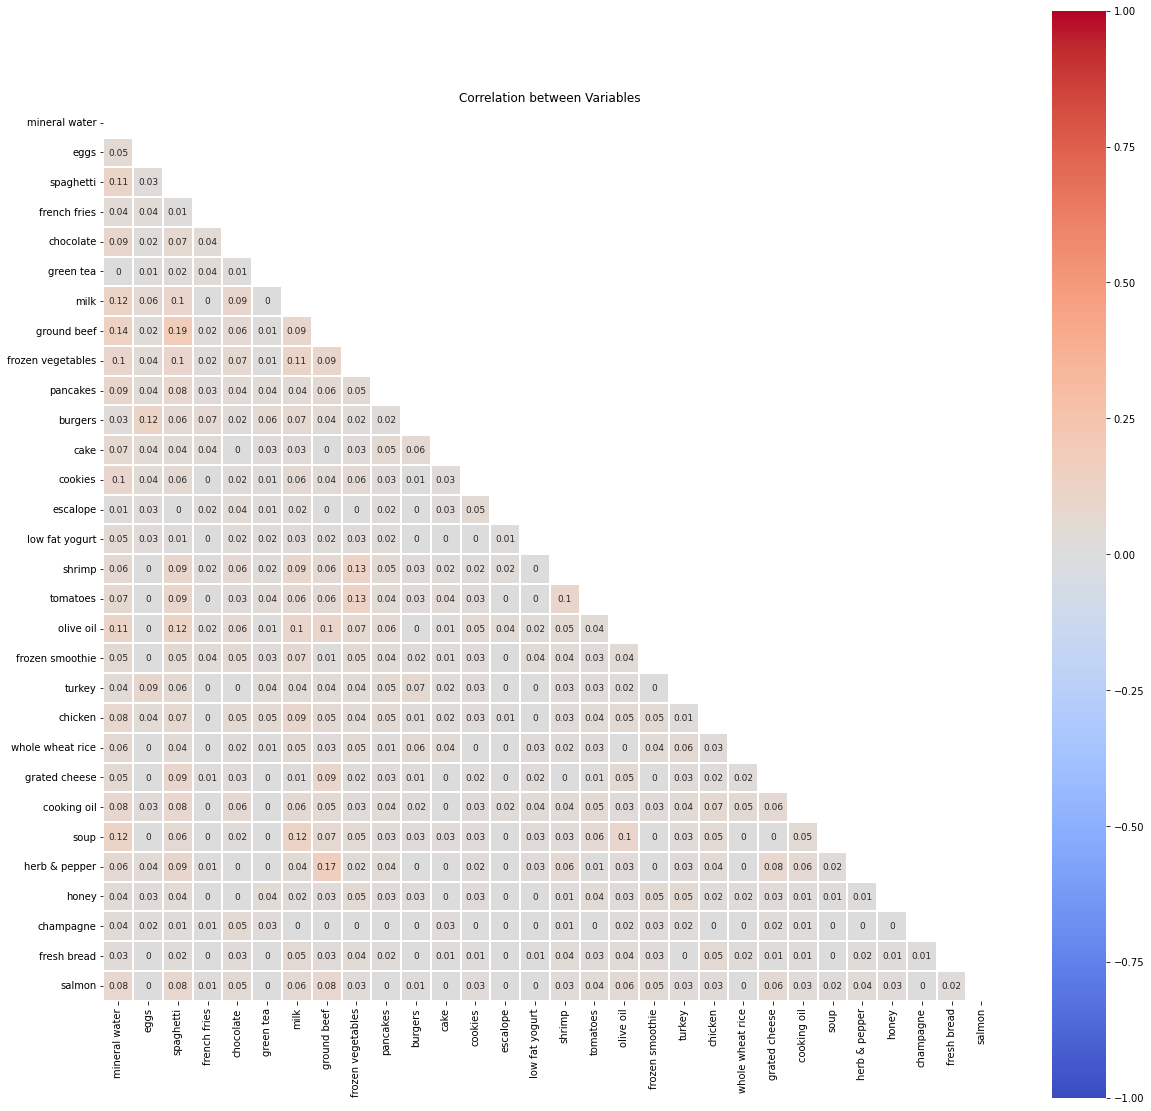

In [19]:
cols = (df.sum() / df.shape[0]).sort_values(ascending=False).head(30).index.tolist()
find_association("cramers_v", df, cols)

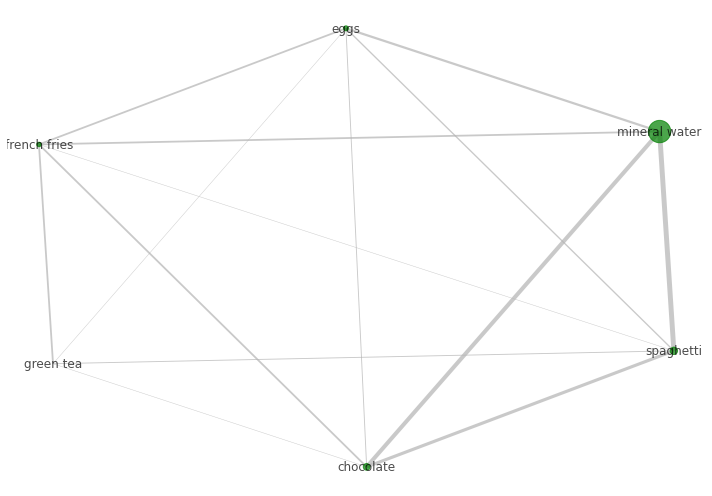

In [20]:
def drawNetworkGraph(df, startNode, nCols = 6):
    """
    Takes input DataFrame & plots network graph based on Association.
    Edges are weighted using correlation.
    df : Transactional DataFrame
    StartNode : 
    
    """
    weightDict = {}
    cols = (df.sum() / df.shape[0]).sort_values(ascending=False).head(6).index.tolist()
    corrDf = find_association("cramers_v", df, cols, plot=False, returnCorr=True)
    weights = corrDf[startNode].sort_values(ascending=False)

    for key, value in zip(weights.index.tolist(), weights.values.tolist()):
        weightDict[key] = value

    combs = [x for x in itertools.combinations(weightDict.keys(), 2)]
    
    edge_width = [round(45 * corrDf[u][v] , 3) for u, v in combs]
    
    G = nx.Graph()
    plt.figure(figsize =(10, 7))
    G.add_node(startNode)
    for items in weightDict.keys():
        G.add_node(items)

    for items in combs:
        G.add_edge(items[0], items[1])
    
    pos = nx.fruchterman_reingold_layout(G)

    nx.draw_networkx(G, pos, with_labels = True, arrowstyle='-|>',
                     alpha = 0.7, width = edge_width,
                     arrows=True, node_size = weights * 500,
                     edge_color ='.7', cmap = plt.cm.Blues, node_color ='green') 
    
    plt.axis('off')
    plt.tight_layout();
    
drawNetworkGraph(df, startNode = 'mineral water', nCols = 6)

In [21]:
def getSupportData(df, min_support=0.05, length=1):
    """
    Returns DataFrame based on min_support & specified length
    """
    
    frequent_itemsets = apriori(df, min_support = min_support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    frequent_itemsets.sort_values(by = ['length'], ascending=False).head(3)
    return frequent_itemsets[(frequent_itemsets['length'] == length) & (frequent_itemsets['support'] >= min_support)]
    
getSupportData(df, min_support=0.05, length=2)

,support,itemsets,length
25,0.051,"(eggs, mineral water)",2
26,0.060,"(spaghetti, mineral water)",2
27,0.053,"(chocolate, mineral water)",2


### Metrics to understand the rules :

- confidence(A→C) = $ \frac{support(A→C)} {support(A)}$ , range: [0,1]

- lift(A→C) = $ \frac{confidence(A→C)}{support(C)}$ , range: [0,∞]

- leverage(A→C) = $ support(A→C) - support(A) × support(C)$ , range: [−1,1]

- conviction(A→C) = $ \frac{1 − support(C)}{1−confidence(A→C)}$ , range: [0,∞]

In [22]:
def getDataBasisMetric(df, min_support=0.02, length=2, min_threshold=0.5, metric='lift', minAntecedentLength=1, ascending=False):
    """
    Rules do not extract an individual’s preference, rather find relationships between set of elements of every distinct transaction.
    
    Association Rule: Ex. {X → Y} is a representation of finding Y on the basket which has X in it.
    X-> Antecedent ; Y-> Consequent
    Itemset: Ex. {X,Y} is a representation of the list of all items which form the association rule.
    
    Support: Fraction of transactions containing the itemset.
    
    Confidence: Probability of occurrence of {Y} given {X} is present (Non-Directional)
    
    Lift: Ratio of confidence to baseline probability of occurrence of {Y}.
    Also used to measure how much more often the antecedent and consequent of a rule A->C occur together
    than we would expect if they were statistically independent. For independent, lift = 1
    
    Leverage : It computes the difference between the observed frequency of A and C appearing together
    and the frequency that would be expected if A and C were independent. 
    A leverage value of 0 indicates total independence.
    
    Conviction : A high conviction value means that the consequent is highly depending on the antecedent. 
    If items are independent, the conviction is 1.
    
    Example : Support says that 67% of customers purchased milk and cheese. 
    Confidence is that 100% of the customers that bought milk also bought cheese.
    Lift represents the 28% increase in expectation that someone will buy cheese, when we know that they bought milk. 
    This is the conditional probability.
    
    """
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    rules["antecedentLength"] = rules["antecedents"].apply(lambda x: len(x))
    return rules[rules["antecedentLength"] >= minAntecedentLength].sort_values(by=metric, ascending=ascending)


# Without rules for pruning, we will need to brute force for 119 items, which is (2^119 - 1) unique itemsets.
# Minimum support : probability of T(i) containing X itemset.
# Here, the item needs to be in 7501 * 0.04 transactions.
# min_threshold : Minimal threshold for the evaluation metric; in this case for lift

getDataBasisMetric(df, min_support=0.04, length=1, min_threshold=0.5, metric='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedentLength
9,(mineral water),(ground beef),0.238,0.098,0.041,0.172,1.748,0.018,1.089,1
8,(ground beef),(mineral water),0.098,0.238,0.041,0.417,1.748,0.018,1.305,1
6,(milk),(mineral water),0.130,0.238,0.048,0.370,1.554,0.017,1.210,1
7,(mineral water),(milk),0.238,0.130,0.048,0.201,1.554,0.017,1.090,1
2,(spaghetti),(mineral water),0.174,0.238,0.060,0.343,1.439,0.018,1.159,1
3,(mineral water),(spaghetti),0.238,0.174,0.060,0.251,1.439,0.018,1.102,1
4,(chocolate),(mineral water),0.164,0.238,0.053,0.321,1.348,0.014,1.122,1
5,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073,1
0,(eggs),(mineral water),0.180,0.238,0.051,0.283,1.189,0.008,1.063,1
1,(mineral water),(eggs),0.238,0.180,0.051,0.214,1.189,0.008,1.043,1


- For the above case of (mineral water) & (ground beef) : leverage is close to 0 which means independence; conviction being close to 1 states the same. Lift shows positive correlation( >1 ) though. We need to deep dive using other metrics. 

- (spaghetti) & (mineral water) has higher confidence stating probability of seeing mineral water in a transaction given that it also contains spaghetti.

In [23]:
data = getDataBasisMetric(df, min_support=0.04, length=1, min_threshold=0.25, metric='lift')
data[data['antecedents'] == {'mineral water'}].sort_values(by=['lift'], ascending=False) # This confirms the correlation aspect.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedentLength
9,(mineral water),(ground beef),0.238,0.098,0.041,0.172,1.748,0.018,1.089,1
7,(mineral water),(milk),0.238,0.130,0.048,0.201,1.554,0.017,1.090,1
3,(mineral water),(spaghetti),0.238,0.174,0.060,0.251,1.439,0.018,1.102,1
5,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073,1
1,(mineral water),(eggs),0.238,0.180,0.051,0.214,1.189,0.008,1.043,1


In [24]:
data = getDataBasisMetric(df, min_support=0.04, length=1, min_threshold=0.25, metric='lift')
data[data['antecedents'] == {'mineral water'}].sort_values(by=['support'], ascending=False) # This confirms the correlation aspect.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedentLength
3,(mineral water),(spaghetti),0.238,0.174,0.060,0.251,1.439,0.018,1.102,1
5,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073,1
1,(mineral water),(eggs),0.238,0.180,0.051,0.214,1.189,0.008,1.043,1
7,(mineral water),(milk),0.238,0.130,0.048,0.201,1.554,0.017,1.090,1
9,(mineral water),(ground beef),0.238,0.098,0.041,0.172,1.748,0.018,1.089,1


In [25]:
getDataBasisMetric(df, min_support=0.05, length=1, min_threshold=0.3, metric='confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedentLength
0,(spaghetti),(mineral water),0.174,0.238,0.060,0.343,1.439,0.018,1.159,1
1,(chocolate),(mineral water),0.164,0.238,0.053,0.321,1.348,0.014,1.122,1


In [26]:
def buildContingency(df, antecedant, precedant):
    data_crosstab = pd.crosstab(df[antecedant], df[precedant], rownames = [antecedant.upper()],
                                colnames=[precedant.upper()], margins = True)
    
    print("\nPivot :")
    print(data_crosstab)
    
    crosstab, resChi , expected = researchpy.crosstab(df[antecedant], df[precedant], 
                                                      test= "chi-square", expected_freqs= True);
    
    print('\nExpected Values')
    print(expected)
    
    print("\nPearson Chi-square :", round(resChi.values[0][1], 3))
    

In [27]:
def validateMetric(df, antecedents, consequents, min_support=0.01, length=1, min_threshold=0.01, metric='lift'):
    """
    If Kulczynski is near 0 or 1, then we have an interesting rule that is negatively or positively associated respectively. 
    If Kulczynski is near 0.5, then we may or may not have an interesting rule.
    Imbalance Ratio where 0 is perfectly balanced and 1 is very skewed.
    So completely uninteresting rules would have both Kulczynski=0.5 and IR=0.
    
    Input : 
    df : Original Dataframe of Encoded Transactions
    antecedents : Antecedent(if) item 
    consequents : Consequent(then) item
    min_support : Value in order to prune candidate rules by specifying a minimum lower bound for the Support.
    Length : Antecedent Length   
    min_threshold : Threshold for Pruning
    metric : Confidence/Lift
    
    """
    data = getDataBasisMetric(df, min_support=0.01, length=1, min_threshold=0.01, metric='lift')
    PA = data[(data['antecedents'] == {antecedents}) & (data['consequents'] == {consequents})]

    kulczynski = round(0.5 * PA['support'].values[0] * \
                       ((1/PA['antecedent support'].values[0]) + (1/PA['consequent support'].values[0])), 4)

    IR = round((PA['antecedent support'].values[0] - PA['consequent support'].values[0])/ \
    (PA['antecedent support'].values[0] + PA['consequent support'].values[0] - PA['support'].values[0]) , 3)
    
    print(f"Kulczynski : {kulczynski} ; Imbalance Ratio : {IR}")


In [28]:
buildContingency(df, antecedant = 'mineral water', precedant = 'ground beef')   


Pivot :
GROUND BEEF       0    1   All
MINERAL WATER                 
0              5283  430  5713
1              1481  307  1788
All            6764  737  7501

Expected Values
              ground beef        
ground beef             0       1
mineral water                    
0               5,151.677 561.323
1               1,612.323 175.677

Pearson Chi-square : 142.933


##### (ground beef)(mineral water) is much rarer than (~ ground beef)(mineral water) & (ground beef)(~ mineral water) but there are many (~ ground beef)(~ mineral water) -> Case of high null-invariant

- But lift = 1.75 > 1 showing +ve correlation.
- χ2 = 142.93 , observed[mineral water & ground beef] (307) > expected (175.68) ; +ve correlation

 It is unlikely that Ground Beef & Mineral Water will happen together, hence, both measure seem to be skewed due to null transactions.

**Note** : Both Lift & χ2 are not null-invariant metrics, hence, we should use Kulczynski with Imbalance Ratio to compensate for the presence of null transactions.
- If Kulczynski is near 0 or 1, then we have an interesting rule that is negatively or positively associated respectively. If Kulczynski is near 0.5, then we may or may not have an interesting rule.
- Imbalance Ratio where 0 is perfectly balanced and 1 is very skewed.
- So completely uninteresting rules would have both Kulczynski=0.5 and IR=0.

##### Kulczynski= $ 1/2( \frac{S(A U B)}{S(A)} + \frac{S(A U B)}{S(B)} ) $

##### IR= $ \frac{|support(A) - support(B)|} {|support(A)+support(B)- support(A∪B)|} $

In [29]:
validateMetric(df, antecedents='mineral water', consequents='ground beef', 
               min_support=0.01, length=1, min_threshold=0.5, metric='lift')

Kulczynski : 0.2941 ; Imbalance Ratio : 0.474


In [30]:
buildContingency(df, antecedant = 'mineral water', precedant = 'spaghetti')   


Pivot :
SPAGHETTI         0     1   All
MINERAL WATER                  
0              4855   858  5713
1              1340   448  1788
All            6195  1306  7501

Expected Values
              spaghetti        
spaghetti             0       1
mineral water                  
0             4,718.309 994.691
1             1,476.691 311.309

Pearson Chi-square : 95.416


- lift = 1.44 > 1 showing +ve correlation.
- χ2 = 95.416 , observed[mineral water & spaghetti] (448) > expected (311) ; +ve correlation

 It is likely that Ground Beef & Spaghetti will happen together(high confidence/ average support), but, both measure seem to be skewed due to null transactions.
 
Using Kulczynski & Imbalance Ratio to validate.

In [31]:
validateMetric(df, antecedents='mineral water', consequents='spaghetti', 
               min_support=0.01, length=1, min_threshold=0.5, metric='lift')

# Higher Balance as ratio is closer to 0.

Kulczynski : 0.2968 ; Imbalance Ratio : 0.182


#### Conclusion

- Lift, χ2 and cosine are good measures if null transactions are not predominant 
- Otherwise, Kulczynski + Imbalance Ratio should be used to judge the interestingness of a pattern

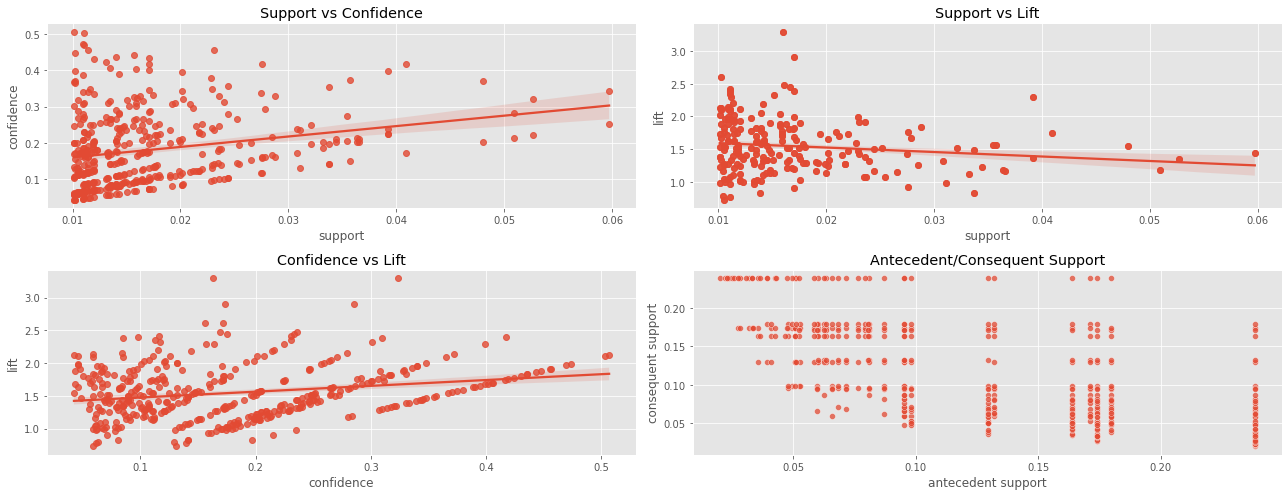

In [32]:
def metricsPlot(rules, alpha=0.95):
    
    titles = ["Support vs Confidence", "Support vs Lift", 
              "Confidence vs Lift", "Antecedent/Consequent Support"]
        
    plt.style.use('ggplot')
    plt.subplot(221)
    plt.title(titles[0])
    sns.regplot(x="support", y="confidence", data=rules)
    plt.subplot(222)
    plt.title(titles[1])
    sns.regplot(x="support", y="lift", data=rules)
    plt.subplot(223)
    plt.title(titles[2])
    sns.regplot(x="confidence", y="lift", data=rules)
    plt.subplot(224)
    plt.title(titles[3])
    sns.scatterplot(x="antecedent support", y="consequent support", data=rules, alpha=alpha)
    plt.tight_layout()
        
        
rules = getDataBasisMetric(df, min_support=0.01, length=1, min_threshold=0.01, metric='lift')
metricsPlot(rules, alpha=0.75)

#### Support & confidence seem to be positively related for the given set of rules & so is lift. 